In [1]:
from __future__ import print_function
from gurobipy import * 
from scipy.spatial import distance
from scipy.spatial.distance import euclidean 
import math
import numpy as np 
from time import time 
import copy 
import random 
from collections import defaultdict 
from math import exp 

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Driver and demand classes to generate objects
# Verified for 1. disagg alg, 2.
class Driver:
    def __init__(self, number, ma, loc, time_first_matched, ha, bar_ha, profit_matching, texit): 
        self.number = number 
        self.ma = ma    # binary=1 if available for matching
        self.loc = loc  # o_a current location 
        self.time_first_matched = time_first_matched
        self.ha = ha    # active time spent up to t
        self.bar_ha = bar_ha    # portion of active time driver is utilized
        self.profit_matching = profit_matching
        self.active_history = []
        self.iteration_history = {}
        self.texit = texit
        
    def __str__(self):
        return 'This is driver no. {self.number}'.format(self=self) + ' self.ma: ' + str(self.ma) + ' self.loc: ' + str(self.loc)  + ' self.time_first_matched: '+ str(self.time_first_matched) + ' self.ha: ' + str(self.ha) + ' self.bar_ha: ' + str(self.bar_ha) + ' self.profit_matching: ' + str(self.profit_matching) + ' self.active_history: ' + str(self.active_history) + ' self.iteration_history: ' + str(self.iteration_history)  
# Verified for 1. disagg alg, 2.
class Demand:
    def __init__(self, number, origin, destination, dist, announce_time, delivery_deadline, value):
        self.number = number
        self.origin = origin
        self.destination = destination
        self.dst = dist
        self.announce_time = announce_time
        self.delivery_deadline = delivery_deadline
        self.value = value
        self.iteration_history = {}

    def __str__(self):
        return 'This is demand no. {self.number}'.format(self=self) + ' self.origin: ' + str(self.origin) + ' self.destination: ' + str(self.destination) + ' self.dst: ' + str(self.dst) + ' self.announce_time: ' + str(self.announce_time) + ' self.delivery_deadline: ' + str(self.delivery_deadline) + ' self.value: ' + str(self.value) + ' self.iteration_history: ' + str(self.iteration_history)         
 
def closest_node(node, loc_set):
    nodes = np.asarray(loc_set)
    closest_ind = distance.cdist([node], nodes).argmin()
    return loc_set[closest_ind]

# Generate a random sample path for 1 iteration
# Verified for 1. disagg alg, 2.
def sample_path(mu_exit, lambd, grid_size, t_interval, T, loc_set, numdrivers_array):
    # select sample path
    m_n = {}
    d_n = {}
    #print('BEGIN SAMPLE PATH')
    for t in range(T):
        m_t = numdrivers_array[t] # realization of random driver entrance
        m_n[t] = m_t
        m_n[t, 'exit'] = np.random.poisson(mu_exit)

        # stopped here 11/25/20 7:27 am
        if m_t > 0:
            for i in range(m_t):
                # set random location of drivers on 10x10 grid
                m_n[t, i] = closest_node([np.random.uniform(0, grid_size[0]), np.random.uniform(0, grid_size[1])],
                                         loc_set)

        # Demand info
        d_t = np.random.poisson(lambd)
        d_n[t] = d_t
        if d_t > 0:
            for i in range(d_t):
                # set random origin and destination locations of drivers on 10x10 grid,
                # random announcement time between 2 epochs
                o_discrete = closest_node([np.random.uniform(0, grid_size[0]), np.random.uniform(0, grid_size[1])],
                                          loc_set)
                d_discrete = closest_node([np.random.uniform(0, grid_size[0]), np.random.uniform(0, grid_size[1])],
                                          loc_set)
                while o_discrete == d_discrete:  # to make sure origin != dest
                    d_discrete = closest_node([np.random.uniform(0, grid_size[0]), np.random.uniform(0, grid_size[1])],
                                              loc_set)
                value_d = np.random.uniform(3, 12)  # 30% of the value of meal, meal value U[10,40]
                d_n[t, i] = [[o_discrete, d_discrete],
                             np.random.uniform(max(0, (t - 1)) * t_interval, t * t_interval), value_d]

    #print('m_n: ', m_n); print('d_n: ', d_n); print('END SAMPLE PATH') 

    return d_n, m_n
  
# compute rho_a (priority score)
def cal_rho_a(bar_ha):
    # rho_a = [[0, 0.8, 1], [1, 0, 0]]
    # rho_b = [[[0, 0.24999999], [0.5, 0.5]], [[0.25, 0.5, 1], [0.25, 0, 0]]]
    if bar_ha < 0.8:
        rho_a = -1.25 * bar_ha + 1  # eqn of line from above
        # rho_a = -0.625 * bar_ha + 1  # changed line to be 0.5 penalty at 0.8  # changed for rho_a_v2
    else:
        rho_a = 0
    return rho_a
  
# compute rho_b (priority score)
def cal_rho_b(perc):  # perc away from min time window to fulfill order
    if perc <= 0.25:
        rho_b = 0.5
    elif perc > 0.5:
        rho_b = 0
    else:
        rho_b = -1 * perc + 0.5  # eqn of line from above points
    return rho_b
 
def cal_theta(dist):
    if dist < 2:
        theta = 4
    elif dist < 5:
        theta = 6
    else:
        theta = 7
    return theta
  
# Step 3.4a: # Done
# This func updates driver and demand attributes after matching.
# Verified for 1. disagg alg, 2. agg alg, 3. Test_VFA_convergence_N
def update_attr(driver_list, demand_list, xab, driver_attr, demand_attr, t, data, x_ab_time, x_ab_cost, aggregate, stats,
                driver_log, driver_stats, demand_stats, num_demand_met):
    # data = {'t_interval': [], 'h_int': [], 'Guaranteed_service': [], 'gamma': [], 'eta': [], 'W': [], 'T': []}
    driver_temp = {'act_av': [], 'act_unav': []}
    drivers = driver_list['act_available']  

    for a in drivers:
        # if driver was not matched at t
        if xab[('a', a)] == 0:  

            busy_time = driver_attr[a].ha
            if driver_attr[a].bar_ha == 0:  # if no prev busy time
                tot_time = data['t_interval']
                if busy_time > 1e-6:  # check
                    print('Possible error here! busy_time > tot_time')
            else:
                tot_time = (driver_attr[a].ha/driver_attr[a].bar_ha) + data['t_interval']
            # total prev time(active time/perc active) + t interval
            bar_ha = round(busy_time/tot_time*100/data['h_int'])*data['h_int']/100
            if bar_ha > 1.0:
                print('Stop and debug!')
            driver_attr[a].bar_ha = bar_ha
            driver_attr[a].profit_matching += x_ab_cost[(a, 0), 'driver'][0]
            driver_attr[a].active_history.append(0)
            driver_temp['act_av'].append(a)
            driver_attr[a].iteration_history[t] = "This driver was not matched at t = " + str(t) \
                                                  + " and is in location " + str(driver_attr[a].loc) + "."
        else:  # Next: continue att update if driver was matched
            b = xab[('a', a)] 
            
            # check if time it takes to make delivery will be before next t
            if x_ab_time[(a, b)] <= (t+1)*data['t_interval']:  # if fulfill delivery before next period
                driver_temp['act_av'].append(a)
                driver_attr[a].active_history.append(1)  # active for one epoch
            # if driver will still be delivering by t+1
            else:
                # unavailable, next time available is x_ab_time or possibly change entry 1 to x_ab_time right away
                driver_attr[a].ma = 0
                driver_attr[a].available_time = x_ab_time[(a, b)]
                # num epochs to fulfill order
                num_epochs = int((x_ab_time[(a, b)] - (t * data['t_interval'])) / data['t_interval'])
                driver_attr[a].active_history += [1 for _ in range(num_epochs)]
                driver_temp['act_unav'].append(a)

            driver_attr[a].profit_matching += x_ab_cost[(a, b), 'driver'][0]
            busy_time = driver_attr[a].ha + (x_ab_time[(a, b)] - t * data['t_interval'])  # additional busy time t
            if driver_attr[a].bar_ha == 0:
                tot_time = (x_ab_time[(a, b)] - t * data['t_interval'])
            else:
                tot_time = (driver_attr[a].ha / driver_attr[a].bar_ha) + (x_ab_time[(a, b)] - t * data['t_interval'])
            if tot_time < 1e-6:
                print('Why is this zero?')  # loc = demand
                perc = 0.0
            else:
                perc = float(busy_time / tot_time)
            driver_attr[a].iteration_history[t] = \
                "This driver was matched with order %d at time t = %d, and is in location %s at time %f." % (b, t,
                                                            str(driver_attr[a].loc),x_ab_time[(a, b)])
            loc = demand_attr[b].destination
            if aggregate:
                loc_1, loc_2 = closest_node(loc, data['loc_set_1']), closest_node(loc, data['loc_set_2'])
            else:
                loc_1, loc_2 = [], []
            driver_attr[a].loc, driver_attr[a].loc_1, driver_attr[a].loc_2 = loc, loc_1, loc_2
            driver_attr[a].ha = busy_time
            bar_ha = round(perc*100/data['h_int'])*data['h_int']/100
            if bar_ha > 1.0:
                print('Stop and debug!')
            driver_attr[a].bar_ha = bar_ha
#             if stats:
#                 driver_log[a]['all_t'].append(['t%d_post_decision' % t,
#                     [demand_attr[b].origin, demand_attr[b].destination, x_ab_time[(a, b)], busy_time,
#                      driver_attr[a].bar_ha]])

    if t > 0:  # check if previously unavailable drivers are now available
        if len(driver_list['act_unavailable']) > 0:
            for a in driver_list['act_unavailable']:
                avail_time = driver_attr[a].available_time
                if avail_time <= (t+1)*data['t_interval']:  # if driver will be avail at t+1 
                    driver_attr[a].ma = 1
                    driver_temp['act_av'].append(a) 
                else:  # if not done delivering, move it to unavailable t+1
                    driver_temp['act_unav'].append(a)

    if stats:
        driver_stats[t, 'active'] = len(driver_temp['act_av']) + len(driver_temp['act_unav'])

    demand_temp = {"active": []}  # Now, move on to update demand info :)
    for b in demand_list['active']:
        if ('b', b) not in xab:  # if demand b is not satisfied carry it forward if not missed
            # if deadline is after t+1 + min time
            if demand_attr[b].delivery_deadline >= ((t+1)*data['t_interval']) + (data['eta']*demand_attr[b].dst):
                demand_temp['active'].append(b)
            else:
                demand_list['expired'].append(b)
                if stats:
                    if 'missed' not in demand_stats:
                        demand_stats['missed'] = []
                    demand_stats['missed'].append(b)
        else:
            num_demand_met[int(demand_attr[b].announce_time//(12*5))] += 1 
            
            demand_list['fulfilled'].append(b)
            if stats:
                if 'met' not in demand_stats:
                    demand_stats['met'] = []
                demand_stats['met'].append(b)
                
    return driver_temp, demand_temp, driver_stats, driver_log, demand_stats, num_demand_met
 
# Verified for 1. disagg alg, 2. agg alg, 3. Test_VFA_convergence_N
def predecision_state(num_drivers, num_demand, driver_temp, demand_temp, driver_list, demand_list, t, n, m, d,
                      driver_attr, demand_attr, data, train, stats=False, driver_stats={}, driver_log=[]):
 
    # (1) check if any drivers are unmatched, if yes, one random leaves if mu_exit>0
    # (2) new arrivals of both drivers and demand from sample path.
    # Note: create complete sample path of n=1 in data generation
      
    if train:  # train = True if training model
        m_n, d_n = m[n], d[n]
    else:
        m_n, d_n = m, d

    if stats and t + 1 >= data['T']:
        pass
    else:  
        # decide on which drivers to exit randomly
#         for a in driver_temp['act_av']:
#             print('exit time: ', driver_attr[a].texit, ' t: ', t, ' exits: ', driver_attr[a].texit<=t)
            
        driver_exit = [a for a in driver_temp['act_av'] if driver_attr[a].texit<=t] 
        #print('len(driver_exit): ', len(driver_exit))
        
        for a in driver_exit:
            
            num_exit[driver_attr[a].time_first_matched//12] += 1 
            
            bar_ha = driver_attr[a].bar_ha
            #print('driver_attr[a].bar_ha: ', driver_attr[a].bar_ha) 
            if driver_attr[a].bar_ha >= data['W']: 
                driver_stats['guarantee_met'].append([a, bar_ha])
                num_meet_guarantee[driver_attr[a].time_first_matched//12]+=1 
            else:
                driver_stats['guarantee_missed'].append([a, bar_ha]) 
                
            driver_list['exit'].append(a)
             
            driver_temp['act_av'].remove(a)

    def update_driver_attr(num_drivers):
        driver_list['act_available'] = copy.copy(driver_temp['act_av'])
        driver_list['act_unavailable'] = copy.copy(driver_temp['act_unav']) 
 
        # new drivers
        if stats and t+1 >= data['T']:
            pass
        else:
            for j in range(m_n[t+1]):  # create new driver objects range(m[n][t+1])
                a = j+num_drivers
                loc = m_n[t+1, j] 
                #print('loc: ', loc) 
                driver_attr[a] = Driver(a, 0, loc, t+1, 0, 0, 0, t+np.random.uniform(24, 84)) 
                driver_list['act_available'].append(a)
            num_drivers += m_n[t+1]
        return num_drivers

    def update_demand_attr(num_demand):
        demand_list['active'] = copy.copy(demand_temp['active'])

        if stats and t+1 >= data['T']:
            pass
        else:
            # new demand
            for j in range(d_n[t+1]):  # no. of new demands
                b = num_demand + j + 1  # unique identifier
                i_loc_o = d_n[t+1, j][0][0]
                i_loc_d = d_n[t+1, j][0][1]
                dst = distance.euclidean(i_loc_o, i_loc_d)
                announce_time = d_n[t+1, j][1]
                announce_time = t*5 #for simplicity it is the epoch when the order is known 
                #print('announce_time: ', announce_time, ' t: ', t)
                value_d = d_n[t+1, j][2]
                demand_attr[b] = Demand(b, i_loc_o, i_loc_d, dst, announce_time, announce_time + data['delta_t'], value_d)
                demand_list['active'].append(b)
            num_demand += d_n[t+1]
        return num_demand

    num_drivers = update_driver_attr(num_drivers)
    num_demand = update_demand_attr(num_demand)
    
    return num_drivers, num_demand, driver_stats, num_meet_guarantee, num_exit

def solve_opt(data, t, n, demand_list, driver_list, driver_attr, demand_attr, v_t, aggregate, penalty, cfa, utilization_deviation_penalty):
    #print('\nFUNCTION SOLVE_OPT\n')
    model_name = 'LP_t%d_n%d' % (t, n)
    mdl = Model(model_name)
    mdl.Params.LogToConsole = 0 #added to suppress Gurobi model's output
    # define decision variables: x_tab
    x_ab_feasible = {('b', b): [] for b in demand_list['active']}
    x_ab_cost, x_ab_time, x_ab_dist, keys = {}, {}, {}, []
    
    drivers = driver_list['act_available'] 
     
    for a in drivers:
        x_ab_feasible[('a', a)] = [0]
        keys.append((a, 0)) 
        
        #print('sa: ', sa)

        #bar_ha is the portion of active time driver is utilized
        if driver_attr[a].bar_ha == 0:
            bar_ha_new = 0
            g = 0
        else:
            if driver_attr[a].bar_ha == 0:
                print('Not sure why bar_ha = %d, ha = %d, sa = %d' % (driver_attr[a].bar_ha,
                                                                      driver_attr[a].ha, sa))
                tot_time = data['t_interval']
            else:
                tot_time = (driver_attr[a].ha / driver_attr[a].bar_ha) + data['t_interval']
            bar_ha_new = round(driver_attr[a].ha / tot_time * 100 / data['h_int']) * data['h_int'] / 100
            g = max(data['Guaranteed_service'] - ((t + 1) * data['t_interval'] - driver_attr[a].time_first_matched), 0)
 
        #print('bar_ha_new: ', bar_ha_new, ' g: ', g)
             
        cost_to_go = 0 #no vf

        if bar_ha_new > data['W']:  # activity time window not over # :
            x_ab_cost[(a, 0)] = 0 + cost_to_go
            x_ab_cost[(a, 0), 'driver'] = [0, 0]
            x_ab_cost[(a, 0), 'platform_profit'] = 0
        else:
            rho_a = cal_rho_a(bar_ha_new)
            x_ab_cost[(a, 0)] = (-penalty * rho_a) + cost_to_go  # penalty = -1000 for high penalty or -1 for regular
            x_ab_cost[(a, 0), 'driver'] = [0, 0]
            x_ab_cost[(a, 0), 'platform_profit'] = 0
            
        #print('\na: ', a); print(driver_attr[a]);  print('loc: ', driver_attr[a].loc)
        
        a_loc = tuple(driver_attr[a].loc)
        #print('continues', ' a_loc: ', a_loc)
        
        #print('\nLOOPING OVER ACTIVE DEMAND\n'); print('a_loc: ', a_loc) 
         
        for b in demand_list['active']:
            #print('\nb: ', b); print(demand_attr[b])
            b_loc_o = tuple(demand_attr[b].origin)
            dst = distance.euclidean(a_loc, b_loc_o) #distance from driver a's origin to demand b's origin 
            #print('dst: ', dst) 
            dst_o_d = demand_attr[b].dst
            dst_tot = dst + dst_o_d  # dst from driver to origin + package orig to dest.
            x_ab_dist[(a, b)] = dst
            x_ab_dist[(a, b, 'tot_dst')] = dst_tot
            cont_time = data['eta'] * dst_tot
            disc_time = math.ceil(cont_time / data['t_interval']) * data['t_interval']
            #disc_time is the time in minutes a takes to deliver b (rounded up to nearest multiple of t_interval, length of decision epoch)
            #print('disc_time: ', disc_time)
            time = disc_time + (t * data['t_interval'])  # time interval + time of t
            #is time when the driver if matched now will fulfil this order? But what if the driver is active? 
            t_epoch = int(time/data['t_interval'])
            #t_epoch = epoch when b is delivered by a if assigned
            
            if time <= demand_attr[b].delivery_deadline and t < driver_attr[a].texit: #float('inf')):  # if can be delivered before deadline
                
                # find aggregate expected location:
                loc = demand_attr[b].destination  # loc of demand dest 
                # 0.6/mile = 0.3728/km = 1.1185/unit (1 unit = 3 km) + $0.2/min
                fixed_charge = 2.5  # fixed charge per pickup and delivery
                driver_pay_ab = (1.1185 * dst_tot + 0.2 * disc_time + fixed_charge)
                driver_profit = 0.75 * driver_pay_ab - (0.5 * 1.1185 * dst_tot)  # pay minus per km cost

                if driver_attr[a].bar_ha == 0:
                    bar_ha_new = 1.0
                    g = max(data['Guaranteed_service'] - disc_time, 0)
                    #g is the remaining time since the driver was first matched to fulfil the guarantee utilization time
                else:
                    if driver_attr[a].bar_ha == 0:
                        print('Not sure why bar_ha = %d, ha = %d' % (driver_attr[a].bar_ha,
                                                                              driver_attr[a].ha))
                        tot_time = disc_time
                    else:
                        tot_time = (driver_attr[a].ha / driver_attr[a].bar_ha) + disc_time
                    bar_ha_new = round((driver_attr[a].ha + disc_time) / tot_time * 100 / data['h_int']) * data['h_int'] / 100
                    g = max(data['Guaranteed_service'] - (time - driver_attr[a].time_first_matched), 0)
                    #g is the remaining time since the driver was first matched to fulfil the guarantee utilization time
                    #(time - driver_attr[a].time_first_matched) is the time the driver has been (or will be when finished 
                    #this order) utilized; if greater than data['Guaranteed_service'], they no longer have any guarantee time left 
                
                #bar_ha_new is the portion of time utilized; must be >= 0.8 or penalty applies
                
                # Fetch VF
                # value of having a driver with such attr in the future (time). # updated 02/08/21
                #key_0 = ('t', t_epoch, 'sa', sa, 'loc', tuple(loc), 'bar_ha', bar_ha_new, 'g', g)
                #vf = fetch_vf(aggregate, key_0, v_t, driver_attr[a])
                #print('vf: ', vf)
                cost_to_go = 0 #no vf
                keys.append((a, b))
                x_ab_feasible[('a', a)].append(b)
                x_ab_feasible[('b', b)].append(a)

                # removed since not parametric cost function
                perc = 1 - float(time / demand_attr[b].delivery_deadline)  # percent of time window remaining
                rho_b = cal_rho_b(perc)
                #rho_b is the priority score; higher rho_b indicates the demand needs to be fulfilled more urgently  
                
                rho_a = cal_rho_a(bar_ha_new)  # get rho_a for each a/b match
                #rho_a is the penalty if bar_ha_new < 0.8
                
                #dst_o_d = b.origin to b.dest 
                theta = cal_theta(dst_o_d) #NOTE: using a piecewise linear function of dist
                phi = demand_attr[b].value
 
                c = theta + phi - 0.5*driver_pay_ab + data['alpha_penalty'] * (rho_a + (1-utilization_deviation_penalty)*rho_b) \
                    - (penalty * rho_a) #maximize c 
                    
                x_ab_cost[(a, b), 'driver'] = [driver_profit, 0]
                x_ab_cost[(a, b), 'platform_profit'] = theta + phi - 0.5*driver_pay_ab
                # under this scenario, driver only earns profit from matching. Paid by platform = 0.

                # Note: right now only accounting for distance from driver to origin
                x_ab_cost[(a, b)] = c
                x_ab_time[(a, b)] = time
        
    x_a_b = {key: mdl.addVar(lb=0, name=f'x_{key[0]}_{key[1]}', vtype = GRB.CONTINUOUS) for key in keys}
  
    mdl.setObjective(quicksum((x_a_b[(a, b)] * x_ab_cost[(a, b)] for a in drivers for b in x_ab_feasible[('a', a)])), GRB.MAXIMIZE)

    # Add constraints in a separate function
    # resource constraint 
     
    a_cnst = mdl.addConstrs(quicksum(x_a_b[(a, b)] for b in x_ab_feasible[('a', a)]) == 1 for a in drivers)

    # demand constraint 
    
    mdl.addConstrs(quicksum(x_a_b[(a, b)] for a in x_ab_feasible[('b', b)]) <= 1 for b in demand_list['active'])
    
    # solve model 
    mdl.optimize()
    # Get obj and var values
    z = mdl.ObjVal

    #print('z = ' + str(z)); print('variables: ', mdl.getVars())
    
    xab = {('b', 0): []} #different from x_a_b variables of the model defined above 
    
    #print('a_cnst: ', a_cnst); print('len a_cnst: ', len(a_cnst));  

    dst, tot_dst, platform_profit = 0, 0, 0
    # Get solution values
    num_matches = 0
    drivers = driver_list['act_available'] 
    
    dual_a = {"all": {i: a_cnst[i].Pi for i in a_cnst}} #changed from cplex version: dual_a = {"all": mdl.dual_values(a_cnst)}

    #print('dual_a: ', dual_a); #print('drivers: ', drivers); print('len(drivers): ', len(drivers)) 
    
    #x_a_b are the model variables, different from xab 
    
    for a in drivers: 
        for b in x_ab_feasible[('a', a)]: 
            #following checks if a is assigned to b; 0.99 instead of 1 for numerical reasons 
            if x_a_b[(a,b)].X >= 0.99: #changed from cplex version: if mdl.xab[(a, b)].solution_value >= 0.99:     
                xab[('a', a)] = b
                if b != 0:
                    dst += x_ab_dist[(a, b)] #dst is from a's origin to b's origin 
                    tot_dst += x_ab_dist[(a, b, 'tot_dst')]
                platform_profit += x_ab_cost[(a, b), 'platform_profit']
                break  # break out of the b loop as soon as you find match
        if xab[('a', a)] != 0:
            xab[('b', b)] = a
            num_matches += 1
        else:
            xab[('b', 0)].append(a)  # driver unmatched
        # Get dual values
        #print('dual_a: ', dual_a, ' i: ', i); #print('dual_a["all"][i]: ' ,dual_a["all"][i])
        dual_a[a] = dual_a["all"][a] #changed from cplex version: dual_a[a] = dual_a["all"][i]
    #print('num of matches = ' + str(num_matches)) 
    
    return xab, z, dual_a, num_matches, x_ab_time, x_ab_cost, dst, tot_dst, platform_profit
 
def boltzmann(V, i): 
    n = 16 
    x_hat_star = [0 for i in range(n)] 
    
    upper_limit = 15 
    
    for j in range(n):
        #d = max([V[(j,k)] for k in range(1, upper_limit+1) if V[(j,k)] != 1e+6]) + 0.0001 - min([V[(j,k)] for k in range(1, upper_limit+1)])
        
        d = max([V[(j,k)] for k in range(1, upper_limit+1)]) + 0.0001 - min([V[(j,k)] for k in range(1, upper_limit+1)])
         
        zeta = i/(10*d)  
        #print('zeta: ', zeta)
        #zeta = 1/(10)  
        
        #zeta = 1000 
        
        W = 0; w = [0 for i in range(upper_limit)]

        for k in range(1, upper_limit+1):
            w[k-1] = exp(-zeta*V[(j, k)])
            W+=w[k-1]
         
        #print(f'value function at period {j}: ', [V[j, k] for k in range(1,16)]); print(); print('\nw: ', w); print()
        
#         print('\nj: ', j); print('\nd: ', d); 
        
#         if W != 0: 
#             print('\nw normalized: ', [x/W for x in w])
#         else:
#             print('\nw not normalized, W is 0: ', w)
            
        u = np.random.uniform(0,W)
        #print('W: ', W, ' w: ', w, ' u: ', u); return
    
        wtemp = 0; 
        k = 0

        while True: 
            wtemp+=w[k]
            if wtemp >= u:
                break 
            k+=1 
            
        x_hat_star[j] = 1+k  

    return x_hat_star   

#Defining the parameters 

#T=5; n = 5; mu_enter = 1; mu_exit = 2; lambd = 2; 

T = 192  # 16 hours --> to cut off the last two at the end
#mu_enter = 2 #not used, using N and p 
mu_exit = 4
lambd = 10; t_interval = 5; delta_t = 18; n = 3000#3 
  
data = {'T': T, 't_interval': 5, 'mu_exit': mu_exit,  # T was saved as 10 in file
        'lambd': lambd, 'delta_t': 18*delta_t, 'N': n, 'grid_size': (10, 10),
        'eta': 0.8, 'W': 0.8, 'theta': (1 / (2 * math.sqrt(200))), 'theta1': 1,
        'gamma': 0.9, 'Guaranteed_service': 120,
        'alpha_penalty': 1.0, 'lambda_initial': 10, 'h_int': 5, 'g_int': 5}
 
cfa = True; penalty = 250; aggregate = True; driver_temp = []; demand_temp = [];
  
v_t = {0: {}, 'count': {}, 'var': {}, 'last_met': {}} 

data['loc_set_0'] = [[0.25+(0.5*x), 0.25+(0.5*y)] for x in range(20) for y in range(20)]

data['loc_set_1'] = [[0.5+x, 0.5+y] for x in range(10) for y in range(10)] 

data['loc_set_2'] = [[1+(2*x), 1+(2*y)] for x in range(5) for y in range(5)] 
  
cfa_str = '_cfa' if cfa else ''
 
driver_attr, demand_attr = {}, {}
obj_val, obj_val_list = {}, []

t_training_begin = time()
   
V = defaultdict(lambda:0); alpha = defaultdict(lambda:0); 
 
utilization_deviation_penalty = 1; utilization_guarantee = 1

L = 1 #service guarantee; fraction demand met  
    
N = [1 for i in range(16)]; #16 periods, each with 12 epochs since each is 12*5 min = 1 h 
#N is initialized arbitrarily, not with continuous approximation  

prob_enter = 0.1 #binomial parameter 
numdrivers_array = [np.random.binomial(N[x//12], prob_enter) for x in range(T)] 
solutions = [] #stores N vectors along with fraction of demand met
  
m = {}; d = {}  
 
#d = np.load(f'demand_data_n=10_inst_1.npz', allow_pickle=True)['d'].tolist()
 
numdrivers_array = [np.random.binomial(N[x//12], prob_enter) for x in range(T)] 

#data['lambd'] = 45

d[1], _ = sample_path(data['mu_exit'], data['lambd'], data['grid_size'], data['t_interval'], data['T'], data['loc_set_0'], numdrivers_array)

for n in range(2, data['N']): #same list of orders in each n iteration for consistent comparison between different N 
    d[n]=d[1] 

frac_drivers_meet_guarantee_overall = []

frac_demand_met_guarantee_overall = []

for n in range(1, data['N']):
    
    print('\n' + color.BOLD + color.RED + 'N IS EQUAL TO: ', n, color.END); print()
    iteration = n 
    
    if n > 1:
        N = boltzmann(V, n) 
    
    #print('\n' + color.BOLD + color.DARKCYAN + 'N vector: ', N, color.END); print()
    
    numdrivers_array = [np.random.binomial(N[x//12], prob_enter) for x in range(T)] 
    
    #print('numdrivers_array: ', numdrivers_array); print(); print('numdrivers_array_period: ', [sum([numdrivers_array[x] for x in range (12*i, 12*(i+1))]) for i in range(16)])
    
    frac_meeting_guarantee = [0 for i in range(16)] 
    frac_demand_met = [0 for i in range(16)]
        
    for k in range(1): 
        #print('k: ', k)
        
        _, m[n] = sample_path(data['mu_exit'], data['lambd'], data['grid_size'], data['t_interval'], data['T'], data['loc_set_0'], numdrivers_array)
 
        #d[n], m[n] = sample_path(data['mu_exit'], data['lambd'], data['grid_size'], data['t_interval'], data['T'], data['loc_set_0'], numdrivers_array)

        #print('d[n], m[n]: ', d[n], m[n])

        obj_val[n] = 0
        driver_list = {'act_available': [], 'act_unavailable': [], 'exit': []}
        demand_list = {'active': [], 'fulfilled': [], 'expired': []}
        v_t[n] = {}  # Don't need it {('g%d' % xx) for xx in range(3)}  # value functions for 3 aggreg. levels.
    #     d[n], m[n] = sample_path(data['mu_enter'], data['mu_exit'], data['lambd'],
    #                                   data['grid_size'], data['t_interval'], data['T'], data['loc_set_0'])

        num_matches_arr = [] #different for each iteration n  
        
        driver_stats = {'guarantee_missed':[], 'guarantee_met':[]}; driver_log = {}  #different for each iteration n 
        demand_stats = {}
        
        num_demand_met = [0 for i in range(16)]    
        num_meet_guarantee = [0 for i in range(16)] 
        num_exit = [0 for i in range(16)] 
        
        # driver numbering restarts each iteration. Active available drivers are moved forward but re-numbered
        for t in range(data['T']): 
            #print('\n' + color.BOLD + color.DARKCYAN + 'T IS EQUAL TO: ', t, color.END); print() 

            #print("\nn = %d, t = %d" % (n, t))
            if t == 0:
                # Initialize driver attrib.
                for i in range(m[n][0]):
                    loc_0 = m[n][t, i] 
                    driver_attr[i] = Driver(i, 0, loc_0, t, 0, 0, 0, np.random.uniform(24, 84))
                    # drivers inactive, available, 0 active time.
                    driver_list['act_available'].append(i)

                for i in range(d[n][0]):  # no. demand from 1 not 0, since 0 means not matched.
                    i_loc_o = d[n][t, i][0][0]  # d[n][t, i][0][0]
                    i_loc_d = d[n][t, i][0][1]
                    dst = distance.euclidean(i_loc_o, i_loc_d)
                    demand_attr[i+1] = Demand(i+1, i_loc_o, i_loc_d, dst, d[n][t, i][1],
                                                   d[n][t, i][1] + data['delta_t'], d[n][t, i][2])
                    demand_list['active'].append(i+1)

                # I'm keeping track of driver no. to give each driver/order a unique identifier at each iter.
                num_drivers = len(driver_list['act_available'])
                num_demand = len(demand_list['active'])

            # Step 3.3: solve optimization problem
            xab, z, dual_a, num_matches, x_ab_time, x_ab_cost, dst, tot_dst, platform_profit = \
            solve_opt(data, t, n, demand_list, driver_list, driver_attr, demand_attr, v_t, aggregate, penalty, cfa, utilization_deviation_penalty)

            obj_val[n] += z 
            
            driver_temp, demand_temp, driver_stats, driver_log, demand_stats, num_demand_met \
            = update_attr(driver_list, demand_list, xab, driver_attr, demand_attr, t, 
            data, x_ab_time, x_ab_cost, aggregate, True, driver_log, driver_stats, demand_stats, num_demand_met) #stats = True 

            # Step 3.5 - compute pre-decision state
            if t < data['T'] - 1:
                num_drivers, num_demand, driver_stats, num_meet_guarantee, num_exit = predecision_state(num_drivers, num_demand, driver_temp, demand_temp,
                                        driver_list, demand_list, t, n, m, d, driver_attr, demand_attr, data, True,
                                                                 True, driver_stats)
         
        #print('m[n]: ', m[n])
        
        #print('num_meet_guarantee: ', num_meet_guarantee); print(); print('num_exit: ', num_exit)
        
        for i in range(16):
            if sum(num_exit[i:]) == 0:
                frac_meeting_guarantee[i] = 1 
                continue 
            frac_meeting_guarantee[i] = sum(num_meet_guarantee[i:])/sum(num_exit[i:])  
        
        num_orders_placed = [sum([d[n][t] for t in range(12*i, 12*(i+1))]) for i in range(16)]
        
        #print(); print('num_orders_placed: ', num_orders_placed)
        
        #print(); print('driver_stats: ', driver_stats)
        
        #[sum([m[n][t] for t in range(12*i, 12*(i+1))]) for i in range(16)]
        
        for i in range(16):
            if sum(num_orders_placed[i:]) == 0:
                frac_demand_met[i] = 1 
                continue 
            frac_demand_met[i] += sum(num_demand_met[i:])/sum(num_orders_placed[i:]) 
            
        obj_val_list.append(obj_val[n])
         
    frac_demand_met = [x/(k+1) for x in frac_demand_met]
    frac_meeting_guarantee = [x/(k+1) for x in frac_meeting_guarantee]
    
    frac_drivers_meet_guarantee_overall.append(frac_meeting_guarantee[0])
    frac_demand_met_guarantee_overall.append(frac_demand_met[0])
    
    solutions.append({'N':N, 'frac_demand_met': frac_demand_met[0], ' frac_meeting_guarantee': frac_meeting_guarantee[0]})
    
    #print('\nFinal frac_demand_met: ', frac_demand_met); 
    
    #print('\nfrac_demand_met: ', frac_demand_met); print(); print('\nfrac_meeting_guarantee: ', frac_meeting_guarantee); print() 
     
    #print('OVERALL: ')
    print({'N':N, 'frac_demand_met': frac_demand_met[0], ' frac_meeting_guarantee': frac_meeting_guarantee[0]})
    
    #iteration = 0 
    
    for p in range(16): 
        V_i_p_Np = utilization_deviation_penalty*(iteration+1)*max((utilization_guarantee-frac_meeting_guarantee[p]), 0)\
        + (1-utilization_deviation_penalty)*(iteration+1)*max((L-frac_demand_met[p]), 0) #+ sum(N[p+1:])  

        #V_i_p_Np = -1.8**(N[p]); V_i_p_Np = 5**(N[p]) 

        if alpha[(p, N[p])] == 0:
            alpha_step_size = 1
        else: 
            alpha_step_size = 1/(alpha[(p, N[p])])**0.5 
        #alpha_step_size = 1/(alpha[(p, N[p])])**0.5 so alpha_step_size should be 1 if never observed
 
        #print('alpha_step_size: ', alpha_step_size)
        
        #print('\np: ', p, ' V_i_p_Np: ', V_i_p_Np, ' alpha_step_size: ', alpha_step_size, ' V.get((p, N[p]),0): ', V.get((p, N[p]),0))
        #print('frac_meeting_guarantee[p]: ', frac_meeting_guarantee[p])
        #print('max((utilization_guarantee-frac_meeting_guarantee[p]), 0): ', max((utilization_guarantee-frac_meeting_guarantee[p]), 0))
        
        V[(p, N[p])] = (1-alpha_step_size)*V.get((p, N[p]),0)+alpha_step_size*V_i_p_Np 
        #print('V[(p, N[p])]: ', V[(p, N[p])])
        
    for p in range(16): 
        alpha[(p, N[p])]+=1 
    
t_training_end = time()
time_algorithm = t_training_end - t_training_begin

obj_val_list, time_algorithm 

#print(); print(solutions)  


N IS EQUAL TO:  1 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
{'N': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'frac_demand_met': 0.2729145211122554, ' frac_meeting_guarantee': 1.0}

N IS EQUAL TO:  2 

{'N': [3, 7, 3, 2, 14, 7, 2, 3, 6, 3, 7, 13, 5, 11, 11, 7], 'frac_demand_met': 1.0, ' frac_meeting_guarantee': 0.76}

N IS EQUAL TO:  3 

{'N': [4, 10, 11, 4, 4, 1, 14, 7, 6, 2, 9, 3, 12, 10, 14, 8], 'frac_demand_met': 1.0, ' frac_meeting_guarantee': 0.7058823529411765}

N IS EQUAL TO:  4 

{'N': [7, 2, 6, 15, 12, 10, 5, 11, 3, 9, 5, 9, 15, 3, 7, 14], 'frac_demand_met': 1.0, ' frac_meeting_guarantee': 0.216}

N IS EQUAL TO:  5 

{'N': [12, 4, 10, 12, 1, 6, 2, 7, 14, 1, 7, 13, 2, 4, 12, 2], 'frac_demand_met': 1.0, ' frac_meeting_guarantee': 0.37606837606837606}

N IS EQUAL TO:  6 

{'N': [1, 12, 9, 10, 1, 2, 4, 15, 13, 10, 3, 8, 8, 1, 5, 5], 'frac_demand_met': 1.0, ' frac_meeting_guarantee': 0.40217391304347827}

N IS EQUAL TO:  7 

KeyboardInterrupt: 

In [2]:
def find_w_from_V(V, iter_): 
    upper_limit = 15 
    V = [None]+V #index is 1-based
    d = max([V[k] for k in range(1, upper_limit+1)]) + 0.0001 - min([V[k] for k in range(1, upper_limit+1)])

    zeta = iter_/(10*d)  
    #print('zeta: ', zeta)
    #zeta = 1/(10)  

    #zeta = 1000 

    W = 0; w = [0 for i in range(upper_limit)]

    for k in range(1, upper_limit+1):
        w[k-1] = exp(-zeta*V[k]) 
        W+=w[k-1]

    if W != 0: 
        print('\nw normalized: ', [x/W for x in w])
    else:
        print('\nw not normalized, W is 0: ', w)

iter_ = 1000 

for i in range(16): 
    print('\n' + color.BOLD + color.RED + 'i: ', i, color.END); print()
    print('value function: ', [V[i, k] for k in range(1,16)]); print()
    find_w_from_V([V[0, k] for k in range(1, 16)], iter_); print()
    print('alpha: ', [alpha[i, k] for k in range(1,16)]); print() 


i:  0 

value function:  [45.36080729166076, 145.61230110633755, 134.84195623933485, 114.72616451387393, 137.25176414468072, 160.57003925192265, 170.72097932315307, 144.47274794566823, 234.47348342730209, 124.45788391733107, 121.33926887655075, 157.40019668284276, 307.9614564107588, 165.37717959211233, 123.95088987022719]


w normalized:  [0.9999999999961675, 2.6314990195731897e-17, 1.5901014828376106e-15, 3.3745476113660083e-12, 6.351640214479677e-16, 8.840196738194508e-20, 1.8521609793681075e-21, 4.061297852922858e-17, 5.298578854665705e-32, 8.293998075301719e-14, 2.719736656676647e-13, 2.955949213110729e-19, 3.720217641512879e-44, 1.4172525380143216e-20, 1.0060316435807609e-13]

alpha:  [1231, 7, 11, 11, 5, 19, 35, 21, 58, 24, 7, 8, 4, 4, 8]


i:  1 

value function:  [145.2178773757475, 46.45791937767601, 169.47030272460404, 123.63761111051157, 123.3575616027583, 132.53671430326364, 567.5284993486231, 135.31020003269498, 122.69327705663537, 140.954529412658, 169.52347165717262, 21

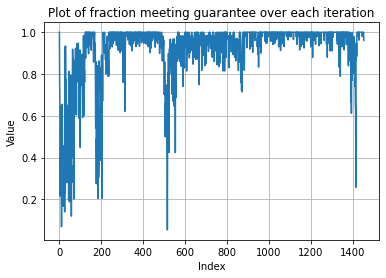

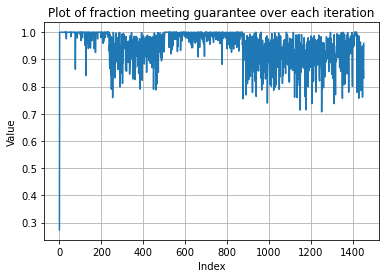

In [3]:
import matplotlib.pyplot as plt
 
plt.plot(frac_drivers_meet_guarantee_overall)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of fraction meeting guarantee over each iteration')
plt.grid()

plt.show()

plt.figure()


plt.plot(frac_demand_met_guarantee_overall)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of fraction meeting guarantee over each iteration')
plt.grid()

plt.show()

In [ ]:
print(frac_drivers_meet_guarantee_overall[-100:])

In [ ]:
len(frac_drivers_meet_guarantee_overall)

In [ ]:
[sum(frac_drivers_meet_guarantee_overall[k] for k in range(100*i, 100*(i+1)) for i in range(10)] 